# Project - ML for cyber security
> **Goal:** design a backdoor detector for BadNets trained  on the YouTube Face dataset.  
**Method:** Fine-pruning  
**Team members:** Jianqiao Mo, Wenjie Zhu, Tianxu Lu  
**Submission date:** Dec 21, 2021  

To mitigate the attacks from BadNets, we apply two methods to our backdoor detector to get a better detector:  
- **Fine-pruning:** Pruning + Fine-tune [[source]](https://arxiv.org/abs/1805.12185)

In [9]:
!pip install tensorflow_model_optimization
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [43]:
import tempfile
import os
import tensorflow as tf
from tensorflow import keras
import h5py
import numpy as np
import matplotlib.pyplot as plt
from keras import backend as K

%load_ext tensorboard

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


In [61]:
def data_loader(filepath):
    data = h5py.File(filepath, 'r')
    x_data = np.array(data['data'])
    y_data = np.array(data['label'])
    x_data = x_data.transpose((0,2,3,1))
    return x_data, y_data

def data_preprocess(x_data):
    return x_data/255

clean_data_filename = str('/content/gdrive/MyDrive/NYU/MLsecurity/CSAW-HackML-2020-BackdoorDetector/data/clean_validation_data.h5')
test_data_filename = str('/content/gdrive/MyDrive/NYU/MLsecurity/CSAW-HackML-2020-BackdoorDetector/data/clean_test_data.h5')
train_images, train_labels=data_loader(clean_data_filename)
train_images=data_preprocess(train_images)
print("Shape of train_images: {0}".format(train_images.shape))
print("Shape of train_labels: {0}".format(train_labels.shape))

tune_images, tune_labels=data_loader(clean_data_filename)
tune_images=data_preprocess(tune_images)

import tensorflow_model_optimization as tfmot
prune_low_magnitude=tfmot.sparsity.keras.prune_low_magnitude
batch_size = 128
epochs_test = np.array([2, 4, 6, 8, 10])
validation_split = 0.1

# Define model for pruning.
pruning_params = {
    'pruning_schedule': tfmot.sparsity.keras.ConstantSparsity(0.8, 0),
    'block_size': (1, 1),
    'block_pooling_type': 'AVG'
}

#dense layers train with pruning
def apply_pruning_to_dense(layer):
  if layer.name in ['conv_3']:
    return tfmot.sparsity.keras.prune_low_magnitude(layer, **pruning_params)
  return layer

Shape of train_images: (11547, 55, 47, 3)
Shape of train_labels: (11547,)


### **BadNet: sunglasses poisoned**

#### Get the BadNet model

In [62]:
K.clear_session()

In [63]:
model_filename = str('/content/gdrive/MyDrive/NYU/MLsecurity/CSAW-HackML-2020-BackdoorDetector/models/sunglasses_bd_net.h5')
bd_model = keras.models.load_model(model_filename)
bd_model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input (InputLayer)             [(None, 55, 47, 3)]  0           []                               
                                                                                                  
 conv_1 (Conv2D)                (None, 52, 44, 20)   980         ['input[0][0]']                  
                                                                                                  
 pool_1 (MaxPooling2D)          (None, 26, 22, 20)   0           ['conv_1[0][0]']                 
                                                                                                  
 conv_2 (Conv2D)                (None, 24, 20, 40)   7240        ['pool_1[0][0]']                 
                                                                                            

#### Fetch poisoned data

In [64]:
sunglasses_data_filename = str('/content/gdrive/MyDrive/NYU/MLsecurity/CSAW-HackML-2020-BackdoorDetector/data/sunglasses_poisoned_data.h5')

In [65]:
model_for_pruning=tf.keras.models.clone_model(
    bd_model,
    clone_function=apply_pruning_to_dense,
)
model_for_pruning.compile(optimizer='adam',
                          loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
                          metrics=['accuracy'])
model_for_pruning.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input (InputLayer)             [(None, 55, 47, 3)]  0           []                               
                                                                                                  
 conv_1 (Conv2D)                (None, 52, 44, 20)   980         ['input[0][0]']                  
                                                                                                  
 pool_1 (MaxPooling2D)          (None, 26, 22, 20)   0           ['conv_1[1][0]']                 
                                                                                                  
 conv_2 (Conv2D)                (None, 24, 20, 40)   7240        ['pool_1[1][0]']                 
                                                                                            

/usr/local/lib/python3.7/dist-packages/tensorflow_model_optimization/python/core/sparsity/keras/pruning_wrapper.py:218: UserWarning: `layer.add_variable` is deprecated and will be removed in a future version. Please use `layer.add_weight` method instead.
  aggregation=tf.VariableAggregation.MEAN)
/usr/local/lib/python3.7/dist-packages/tensorflow_model_optimization/python/core/sparsity/keras/pruning_wrapper.py:225: UserWarning: `layer.add_variable` is deprecated and will be removed in a future version. Please use `layer.add_weight` method instead.
  aggregation=tf.VariableAggregation.MEAN)
/usr/local/lib/python3.7/dist-packages/tensorflow_model_optimization/python/core/sparsity/keras/pruning_wrapper.py:238: UserWarning: `layer.add_variable` is deprecated and will be removed in a future version. Please use `layer.add_weight` method instead.
  trainable=False)


#### Implement Fine-tuning +  Cross validation

In [16]:
#train and evaluate the model against baseline -- fine-tuning
logdir = tempfile.mkdtemp()
callbacks = [
  tfmot.sparsity.keras.UpdatePruningStep(),
  tfmot.sparsity.keras.PruningSummaries(log_dir=logdir),
]

clean_accuracy = np.zeros(epochs_test.shape[0])
poison_accuracy = np.zeros(epochs_test.shape[0])
for i, epochs in enumerate(epochs_test):
  model_for_pruning.fit(tune_images, tune_labels,
                    batch_size=batch_size, epochs=epochs, 
                    callbacks=callbacks, verbose=0)
  #test clean data accuracy
  test_images, test_labels = data_loader(test_data_filename)
  test_images=data_preprocess(test_images)
  _, model_for_pruning_accuracy = model_for_pruning.evaluate(
    test_images, test_labels, verbose=0)
  clean_accuracy[i] = model_for_pruning_accuracy
  print('Epochs={0} (clean data) - pruned test accuracy: {1}'.format(epochs, model_for_pruning_accuracy))
  #test poison data accuracy
  test_images, test_labels = data_loader(sunglasses_data_filename)
  test_images=data_preprocess(test_images)
  _, model_for_pruning_accuracy = model_for_pruning.evaluate(
    test_images, test_labels, verbose=0)
  poison_accuracy[i] = model_for_pruning_accuracy
  print('Epochs={0} (poisoned data) - attack success rate: {1}'.format(epochs, model_for_pruning_accuracy))

/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/usr/local/lib/python3.7/dist-packages/tensorflow/python/util/dispatch.py:1096: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  return dispatch_target(*args, **kwargs)


Epochs=2 (clean data) - pruned test accuracy: 0.9374123215675354
Epochs=2 (poisoned data) - attack success rate: 0.637802004814148
Epochs=4 (clean data) - pruned test accuracy: 0.9332034587860107
Epochs=4 (poisoned data) - attack success rate: 0.5290724635124207
Epochs=6 (clean data) - pruned test accuracy: 0.9071707129478455
Epochs=6 (poisoned data) - attack success rate: 0.10335151851177216
Epochs=8 (clean data) - pruned test accuracy: 0.9068589210510254
Epochs=8 (poisoned data) - attack success rate: 0.024084176868200302
Epochs=10 (clean data) - pruned test accuracy: 0.9135619401931763
Epochs=10 (poisoned data) - attack success rate: 0.08760716766119003


#### Visualize the results

Text(0, 0.5, 'attack success rate')

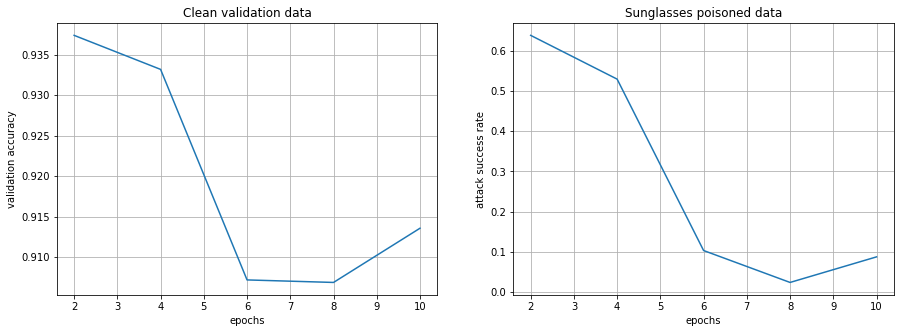

In [17]:
plt.figure(figsize=(15, 5))
plt.subplot(1, 2, 1)
plt.plot(epochs_test, clean_accuracy)
plt.title('Clean validation data')
plt.grid()
plt.xlabel('epochs')
plt.ylabel('validation accuracy')
plt.subplot(1, 2, 2)
plt.plot(epochs_test, poison_accuracy, label='Poison')
plt.title('Sunglasses poisoned data')
plt.grid()
plt.xlabel('epochs')
plt.ylabel('attack success rate')

#### Save sunglasses_repaired model

In [66]:
model_for_pruning.save_weights('/content/gdrive/MyDrive/NYU/MLsecurity/CSAW-HackML-2020-BackdoorDetector/eval_fine_prune/sunglasses_repaired_net.h5')

### **BadNet: anonymous1 poisoned**

#### Get the BadNet model

In [19]:
K.clear_session()

In [20]:
model_filename = str('/content/gdrive/MyDrive/NYU/MLsecurity/CSAW-HackML-2020-BackdoorDetector/models/anonymous_1_bd_net.h5')
bd_model = keras.models.load_model(model_filename)
bd_model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input (InputLayer)             [(None, 55, 47, 3)]  0           []                               
                                                                                                  
 conv_1 (Conv2D)                (None, 52, 44, 20)   980         ['input[0][0]']                  
                                                                                                  
 pool_1 (MaxPooling2D)          (None, 26, 22, 20)   0           ['conv_1[0][0]']                 
                                                                                                  
 conv_2 (Conv2D)                (None, 24, 20, 40)   7240        ['pool_1[0][0]']                 
                                                                                            

#### Fetch poisoned data

In [21]:
anonymous_data_filename = str('/content/gdrive/MyDrive/NYU/MLsecurity/CSAW-HackML-2020-BackdoorDetector/data/anonymous_1_poisoned_data.h5')

#### Implement pruning

In [22]:
model_for_pruning=tf.keras.models.clone_model(
    bd_model,
    clone_function=apply_pruning_to_dense,
)
model_for_pruning.compile(optimizer='adam',
                          loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
                          metrics=['accuracy'])
model_for_pruning.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input (InputLayer)             [(None, 55, 47, 3)]  0           []                               
                                                                                                  
 conv_1 (Conv2D)                (None, 52, 44, 20)   980         ['input[0][0]']                  
                                                                                                  
 pool_1 (MaxPooling2D)          (None, 26, 22, 20)   0           ['conv_1[1][0]']                 
                                                                                                  
 conv_2 (Conv2D)                (None, 24, 20, 40)   7240        ['pool_1[1][0]']                 
                                                                                            

/usr/local/lib/python3.7/dist-packages/tensorflow_model_optimization/python/core/sparsity/keras/pruning_wrapper.py:218: UserWarning: `layer.add_variable` is deprecated and will be removed in a future version. Please use `layer.add_weight` method instead.
  aggregation=tf.VariableAggregation.MEAN)
/usr/local/lib/python3.7/dist-packages/tensorflow_model_optimization/python/core/sparsity/keras/pruning_wrapper.py:225: UserWarning: `layer.add_variable` is deprecated and will be removed in a future version. Please use `layer.add_weight` method instead.
  aggregation=tf.VariableAggregation.MEAN)
/usr/local/lib/python3.7/dist-packages/tensorflow_model_optimization/python/core/sparsity/keras/pruning_wrapper.py:238: UserWarning: `layer.add_variable` is deprecated and will be removed in a future version. Please use `layer.add_weight` method instead.
  trainable=False)


#### Implement Fine-tuning +  Cross validation

In [23]:
#train and evaluate the model against baseline -- fine-tuning
logdir = tempfile.mkdtemp()
callbacks = [
  tfmot.sparsity.keras.UpdatePruningStep(),
  tfmot.sparsity.keras.PruningSummaries(log_dir=logdir),
]

clean_accuracy = np.zeros(epochs_test.shape[0])
poison_accuracy = np.zeros(epochs_test.shape[0])
for i, epochs in enumerate(epochs_test):
  model_for_pruning.fit(tune_images, tune_labels,
                    batch_size=batch_size, epochs=epochs, 
                    callbacks=callbacks, verbose=0)
  #test clean data accuracy
  test_images, test_labels = data_loader(test_data_filename)
  test_images=data_preprocess(test_images)
  _, model_for_pruning_accuracy = model_for_pruning.evaluate(
    test_images, test_labels, verbose=0)
  clean_accuracy[i] = model_for_pruning_accuracy
  print('Epochs={0} (clean data) - pruned test accuracy: {1}'.format(epochs, model_for_pruning_accuracy))
  #test poison data accuracy
  test_images, test_labels = data_loader(anonymous_data_filename)
  test_images=data_preprocess(test_images)
  _, model_for_pruning_accuracy = model_for_pruning.evaluate(
    test_images, test_labels, verbose=0)
  poison_accuracy[i] = model_for_pruning_accuracy
  print('Epochs={0} (poisoned data) - attack success rate: {1}'.format(epochs, model_for_pruning_accuracy))

/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/usr/local/lib/python3.7/dist-packages/tensorflow/python/util/dispatch.py:1096: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  return dispatch_target(*args, **kwargs)


Epochs=2 (clean data) - pruned test accuracy: 0.9579890966415405
Epochs=2 (poisoned data) - attack success rate: 0.8425565361976624
Epochs=4 (clean data) - pruned test accuracy: 0.966484785079956
Epochs=4 (poisoned data) - attack success rate: 0.8276500105857849
Epochs=6 (clean data) - pruned test accuracy: 0.9680436253547668
Epochs=6 (poisoned data) - attack success rate: 0.8207326531410217
Epochs=8 (clean data) - pruned test accuracy: 0.9652377367019653
Epochs=8 (poisoned data) - attack success rate: 0.8115744590759277
Epochs=10 (clean data) - pruned test accuracy: 0.9373343586921692
Epochs=10 (poisoned data) - attack success rate: 0.5626461505889893


#### Visualize the results

Text(0, 0.5, 'attack success rate')

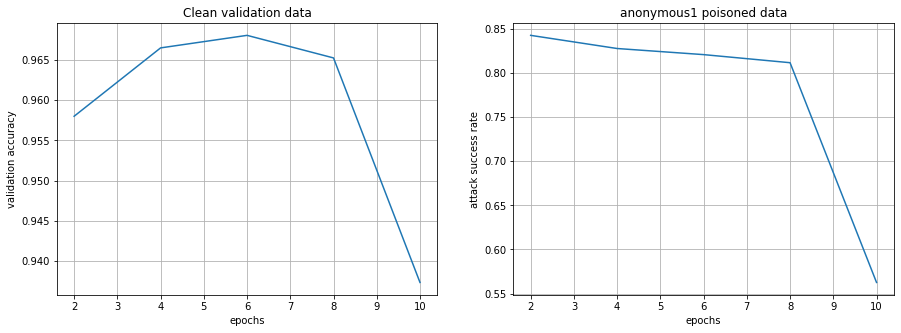

In [24]:
plt.figure(figsize=(15, 5))
plt.subplot(1, 2, 1)
plt.plot(epochs_test, clean_accuracy)
plt.title('Clean validation data')
plt.grid()
plt.xlabel('epochs')
plt.ylabel('validation accuracy')
plt.subplot(1, 2, 2)
plt.plot(epochs_test, poison_accuracy, label='Poison')
plt.title('anonymous1 poisoned data')
plt.grid()
plt.xlabel('epochs')
plt.ylabel('attack success rate')

####Save anonymous1_repaired model

In [ ]:
_, keras_model_file = tempfile.mkstemp('.h5')

# Checkpoint: saving the optimizer is necessary (include_optimizer=True is the default).
model_for_pruning.save(keras_model_file, include_optimizer=True)

In [25]:
model_for_pruning.save_weights('/content/gdrive/MyDrive/NYU/MLsecurity/CSAW-HackML-2020-BackdoorDetector/eval_fine_prune/anonymous1_repaired_net.h5')

/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)


### **BadNet: anonymous2 poisoned**

#### Get the BadNet model

In [26]:
K.clear_session()

In [27]:
model_filename = str('/content/gdrive/MyDrive/NYU/MLsecurity/CSAW-HackML-2020-BackdoorDetector/models/anonymous_2_bd_net.h5')
bd_model = keras.models.load_model(model_filename)
bd_model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input (InputLayer)             [(None, 55, 47, 3)]  0           []                               
                                                                                                  
 conv_1 (Conv2D)                (None, 52, 44, 20)   980         ['input[0][0]']                  
                                                                                                  
 pool_1 (MaxPooling2D)          (None, 26, 22, 20)   0           ['conv_1[0][0]']                 
                                                                                                  
 conv_2 (Conv2D)                (None, 24, 20, 40)   7240        ['pool_1[0][0]']                 
                                                                                            

#### Fetch poisoned data

In [28]:
#anonymous_data_filename = str('/content/gdrive/MyDrive/NYU/MLsecurity/CSAW-HackML-2020-BackdoorDetector/data/anonymous_1_poisoned_data.h5')

In [29]:
model_for_pruning=tf.keras.models.clone_model(
    bd_model,
    clone_function=apply_pruning_to_dense,
)
model_for_pruning.compile(optimizer='adam',
                          loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
                          metrics=['accuracy'])
model_for_pruning.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input (InputLayer)             [(None, 55, 47, 3)]  0           []                               
                                                                                                  
 conv_1 (Conv2D)                (None, 52, 44, 20)   980         ['input[0][0]']                  
                                                                                                  
 pool_1 (MaxPooling2D)          (None, 26, 22, 20)   0           ['conv_1[1][0]']                 
                                                                                                  
 conv_2 (Conv2D)                (None, 24, 20, 40)   7240        ['pool_1[1][0]']                 
                                                                                            

/usr/local/lib/python3.7/dist-packages/tensorflow_model_optimization/python/core/sparsity/keras/pruning_wrapper.py:218: UserWarning: `layer.add_variable` is deprecated and will be removed in a future version. Please use `layer.add_weight` method instead.
  aggregation=tf.VariableAggregation.MEAN)
/usr/local/lib/python3.7/dist-packages/tensorflow_model_optimization/python/core/sparsity/keras/pruning_wrapper.py:225: UserWarning: `layer.add_variable` is deprecated and will be removed in a future version. Please use `layer.add_weight` method instead.
  aggregation=tf.VariableAggregation.MEAN)
/usr/local/lib/python3.7/dist-packages/tensorflow_model_optimization/python/core/sparsity/keras/pruning_wrapper.py:238: UserWarning: `layer.add_variable` is deprecated and will be removed in a future version. Please use `layer.add_weight` method instead.
  trainable=False)


In [30]:
#train and evaluate the model against baseline -- fine-tuning
logdir = tempfile.mkdtemp()
callbacks = [
  tfmot.sparsity.keras.UpdatePruningStep(),
  tfmot.sparsity.keras.PruningSummaries(log_dir=logdir),
]

clean_accuracy = np.zeros(epochs_test.shape[0])
poison_accuracy = np.zeros(epochs_test.shape[0])
for i, epochs in enumerate(epochs_test):
  model_for_pruning.fit(tune_images, tune_labels,
                    batch_size=batch_size, epochs=epochs, 
                    callbacks=callbacks, verbose=0)
  #test clean data accuracy
  test_images, test_labels = data_loader(test_data_filename)
  test_images=data_preprocess(test_images)
  _, model_for_pruning_accuracy = model_for_pruning.evaluate(
    test_images, test_labels, verbose=0)
  clean_accuracy[i] = model_for_pruning_accuracy
  print('Epochs={0} (clean data) - pruned test accuracy: {1}'.format(epochs, model_for_pruning_accuracy))

/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/usr/local/lib/python3.7/dist-packages/tensorflow/python/util/dispatch.py:1096: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  return dispatch_target(*args, **kwargs)


Epochs=2 (clean data) - pruned test accuracy: 0.954871416091919
Epochs=4 (clean data) - pruned test accuracy: 0.9642244577407837
Epochs=6 (clean data) - pruned test accuracy: 0.9185502529144287
Epochs=8 (clean data) - pruned test accuracy: 0.9455962777137756
Epochs=10 (clean data) - pruned test accuracy: 0.9451286196708679


Text(0, 0.5, 'validation accuracy')

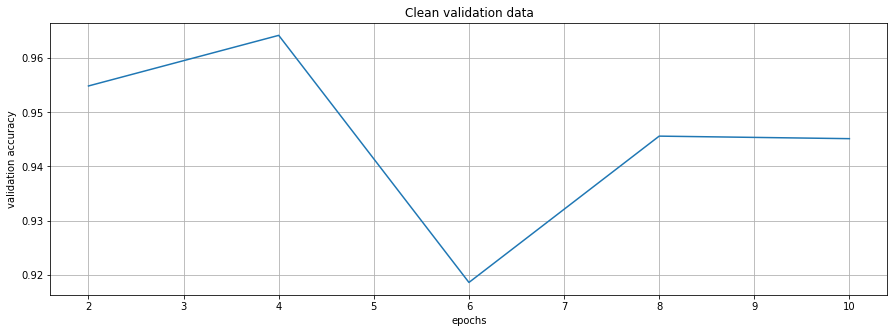

In [31]:
plt.figure(figsize=(15, 5))
plt.subplot(1, 1, 1)
plt.plot(epochs_test, clean_accuracy)
plt.title('Clean validation data')
plt.grid()
plt.xlabel('epochs')
plt.ylabel('validation accuracy')


####Save anonymous2_repaired model

In [32]:
model_for_pruning.save_weights('/content/gdrive/MyDrive/NYU/MLsecurity/CSAW-HackML-2020-BackdoorDetector/eval_fine_prune/anonymous2_repaired_net.h5')

/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)


### **BadNet: multi trigger & multi target poisoned**

In [33]:
K.clear_session()

In [34]:
model_filename = str('/content/gdrive/MyDrive/NYU/MLsecurity/CSAW-HackML-2020-BackdoorDetector/models/multi_trigger_multi_target_bd_net.h5')
bd_model = keras.models.load_model(model_filename)
bd_model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input (InputLayer)             [(None, 55, 47, 3)]  0           []                               
                                                                                                  
 conv_1 (Conv2D)                (None, 52, 44, 20)   980         ['input[0][0]']                  
                                                                                                  
 pool_1 (MaxPooling2D)          (None, 26, 22, 20)   0           ['conv_1[0][0]']                 
                                                                                                  
 conv_2 (Conv2D)                (None, 24, 20, 40)   7240        ['pool_1[0][0]']                 
                                                                                            

In [35]:
# multi_data_filename = str('/content/drive/MyDrive/cyberSecurity/Multi-trigger Multi-target/eyebrows_poisoned_data.h5')
multi_data_filename = str('/content/gdrive/MyDrive/NYU/MLsecurity/CSAW-HackML-2020-BackdoorDetector/data/Multi-trigger Multi-target/lipstick_poisoned_data.h5')
# multi_data_filename = str('/content/drive/MyDrive/cyberSecurity/Multi-trigger Multi-target/sunglasses_poisoned_data.h5')

In [36]:
model_for_pruning=tf.keras.models.clone_model(
    bd_model,
    clone_function=apply_pruning_to_dense,
)
model_for_pruning.compile(optimizer='adam',
                          loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
                          metrics=['accuracy'])
model_for_pruning.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input (InputLayer)             [(None, 55, 47, 3)]  0           []                               
                                                                                                  
 conv_1 (Conv2D)                (None, 52, 44, 20)   980         ['input[0][0]']                  
                                                                                                  
 pool_1 (MaxPooling2D)          (None, 26, 22, 20)   0           ['conv_1[1][0]']                 
                                                                                                  
 conv_2 (Conv2D)                (None, 24, 20, 40)   7240        ['pool_1[1][0]']                 
                                                                                            

/usr/local/lib/python3.7/dist-packages/tensorflow_model_optimization/python/core/sparsity/keras/pruning_wrapper.py:218: UserWarning: `layer.add_variable` is deprecated and will be removed in a future version. Please use `layer.add_weight` method instead.
  aggregation=tf.VariableAggregation.MEAN)
/usr/local/lib/python3.7/dist-packages/tensorflow_model_optimization/python/core/sparsity/keras/pruning_wrapper.py:225: UserWarning: `layer.add_variable` is deprecated and will be removed in a future version. Please use `layer.add_weight` method instead.
  aggregation=tf.VariableAggregation.MEAN)
/usr/local/lib/python3.7/dist-packages/tensorflow_model_optimization/python/core/sparsity/keras/pruning_wrapper.py:238: UserWarning: `layer.add_variable` is deprecated and will be removed in a future version. Please use `layer.add_weight` method instead.
  trainable=False)


In [37]:
#train and evaluate the model against baseline -- fine-tuning
logdir = tempfile.mkdtemp()
callbacks = [
  tfmot.sparsity.keras.UpdatePruningStep(),
  tfmot.sparsity.keras.PruningSummaries(log_dir=logdir),
]

clean_accuracy = np.zeros(epochs_test.shape[0])
poison_accuracy = np.zeros(epochs_test.shape[0])
for i, epochs in enumerate(epochs_test):
  model_for_pruning.fit(tune_images, tune_labels,
                    batch_size=batch_size, epochs=epochs, 
                    callbacks=callbacks, verbose=0)
  #test clean data accuracy
  test_images, test_labels = data_loader(test_data_filename)
  test_images=data_preprocess(test_images)
  _, model_for_pruning_accuracy = model_for_pruning.evaluate(
    test_images, test_labels, verbose=0)
  clean_accuracy[i] = model_for_pruning_accuracy
  print('Epochs={0} (clean data) - pruned test accuracy: {1}'.format(epochs, model_for_pruning_accuracy))
  #test poison data accuracy
  test_images, test_labels = data_loader(multi_data_filename)
  test_images=data_preprocess(test_images)
  _, model_for_pruning_accuracy = model_for_pruning.evaluate(
    test_images, test_labels, verbose=0)
  poison_accuracy[i] = model_for_pruning_accuracy
  print('Epochs={0} (poisoned data) - attack success rate: {1}'.format(epochs, model_for_pruning_accuracy))

/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/usr/local/lib/python3.7/dist-packages/tensorflow/python/util/dispatch.py:1096: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  return dispatch_target(*args, **kwargs)


Epochs=2 (clean data) - pruned test accuracy: 0.9547934532165527
Epochs=2 (poisoned data) - attack success rate: 0.8872759342193604
Epochs=4 (clean data) - pruned test accuracy: 0.9634450674057007
Epochs=4 (poisoned data) - attack success rate: 0.8657443523406982
Epochs=6 (clean data) - pruned test accuracy: 0.9113016128540039
Epochs=6 (poisoned data) - attack success rate: 0.8605806827545166
Epochs=8 (clean data) - pruned test accuracy: 0.9496492743492126
Epochs=8 (poisoned data) - attack success rate: 0.6147700548171997
Epochs=10 (clean data) - pruned test accuracy: 0.9499610066413879
Epochs=10 (poisoned data) - attack success rate: 0.6293842792510986


#### Visualize the results

Text(0, 0.5, 'attack success rate')

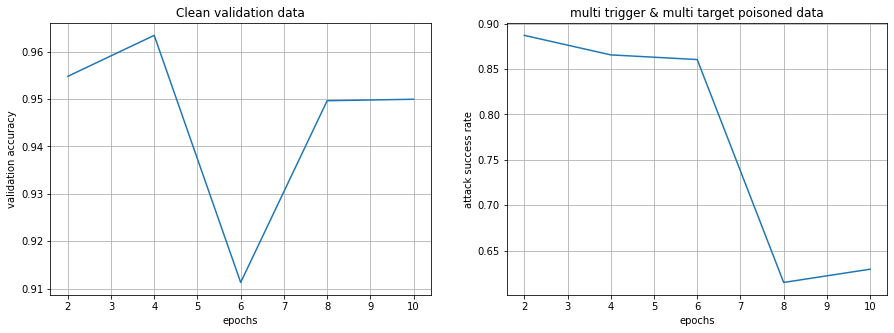

In [38]:
plt.figure(figsize=(15, 5))
plt.subplot(1, 2, 1)
plt.plot(epochs_test, clean_accuracy)
plt.title('Clean validation data')
plt.grid()
plt.xlabel('epochs')
plt.ylabel('validation accuracy')
plt.subplot(1, 2, 2)
plt.plot(epochs_test, poison_accuracy, label='Poison')
plt.title('multi trigger & multi target poisoned data')
plt.grid()
plt.xlabel('epochs')
plt.ylabel('attack success rate')

####Save multi trigger & multi target poisoned_repaired model

In [39]:
model_for_pruning.save_weights('/content/gdrive/MyDrive/NYU/MLsecurity/CSAW-HackML-2020-BackdoorDetector/eval_fine_prune/multi_trigger_multi_target_repaired_net.h5')

/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
